# Classification of forest change using CSC's Puhti supercomputer

You can get acces to CSC's services from https://research.csc.fi/

### Import neccessary libraries

In [2]:
import os, time
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
import numpy as np
import rasterio
from rasterio.merge import merge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from matplotlib import pyplot as plt

### Load features and labels

In [3]:
base_folder = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa'
csv_path = os.path.join(base_folder,'uusimaa_signatures_and_features_max_VH.csv')
model_path = os.path.join(base_folder,'uusimaa_model.pkl')

In [4]:
def load_signatures(sig_csv_path, sig_datatype=np.int32):
    """
    Extracts features and class labels from a signature CSV
    Parameters
    ----------
    sig_csv_path : str
        The path to the csv
    sig_datatype : dtype, optional
        The type of pixel data in the signature CSV. Defaults to np.int32

    Returns
    -------
    features : array_like
        a numpy array of the shape (feature_count, sample_count)
    class_labels : array_like of int
        a 1d numpy array of class labels corresponding to the samples in features.

    """
    data = np.genfromtxt(sig_csv_path, delimiter=",", dtype=sig_datatype).T
    return (data[1:, :].T, data[0, :])


In [5]:
features, labels = load_signatures(csv_path,np.float64)

In [6]:
# Check the shape of the features
features.shape

(31245, 27)

### Set path to input and prediction image 

In [7]:
base_folder = "/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa"
inputImage = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/training_data/UM_max_VH_training.tif'
#inputImage = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/UM_max_VH_ratio_db_training2.tif'
#inputImage = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/UM_max_VH_pca_training.tif'
#inputImage = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/UM_mean_VH_bitemporal_training2.tif'

outputImageBase = 'forest_loss_VH_max_'

In [8]:
# Set the number of available cores
n_jobs=4

You can use random undersampling if the training data is unbalanced. In this study it was skipped

In [8]:
rus = RandomUnderSampler(random_state=63)
pixels_resampled, labels_resampled = rus.fit_resample(features, labels)   
print ('Dataframe shape after undersampling of majority classes, 2D: ', pixels_resampled.shape)

Dataframe shape after undersampling of majority classes, 2D:  (28131, 27)


In [9]:
pixels_resampled.dump('pixels_resampled')
labels_resampled.dump('labels_resampled')
pixels_resampled = np.load('pixels_resampled', allow_pickle=True)
labels_resampled = np.load('labels_resampled', allow_pickle=True)

### Split the training dataset training and test data 

In [9]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=63)
np.unique(y_train, return_counts=True)

(array([1., 2., 3.]), array([7859, 7473, 9664]))

### Functions to train the model, estimate it's performance and do the prediction

In [10]:
# Training the model
# Train the model and see how long it took.
# Credits: https://github.com/csc-training/geocomputing/blob/master/machineLearning/02_shallows/05_classification.ipynb
def trainModel(x_train, y_train, clf, classifierName):
    start_time = time.time()    
    # training the model
    clf.fit(x_train, y_train)
    print('Model training took: ', round((time.time() - start_time), 2), ' seconds')
    
    # Save the model to a file
    modelFilePath = os.path.join(base_folder, ('model_' + classifierName + '.sav'))
    dump(clf, modelFilePath) 
    return clf

In [11]:
# Predict on test data and see the model accuracy
# Credicts: https://github.com/csc-training/geocomputing/blob/master/machineLearning/02_shallows/05_classification.ipynb
def estimateModel(clf, x_test, y_test):
    test_predictions = clf.predict(x_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, test_predictions))
    print('Classification report: \n', classification_report(y_test, test_predictions))

In [12]:
# Predict on whole image and save it as .tif file
# Credits: https://github.com/csc-training/geocomputing/blob/master/machineLearning/02_shallows/05_classification.ipynb
def predictImage(modelName, predictImage):
    #Set file paths for input and output files
    predictedClassesFile = outputImageBase + modelName + '.tif'
    predictedClassesPath = os.path.join(base_folder, predictedClassesFile)
    
    # Read the satellite image
    with rasterio.open(predictImage, 'r') as image_dataset:
        start_time = time.time()    
        
        #Reshape data to 1D as we did before model training
        #image_data = image_dataset.read()
        image_data = image_dataset.read()
        image_data2 = np.transpose(image_data, (1, 2, 0))
        #pixels = image_data2.reshape(-1, 22)
        pixels = image_data2.reshape(-1, 27)
        #Load the model from the saved file
        modelFilePath = os.path.join(base_folder, ('model_' + modelName + '.sav'))
        trained_model = load(modelFilePath)
        
        # predict the class for each pixel
        prediction = trained_model.predict(pixels)
        
        # Reshape back to 2D
        print('Prediction shape in 1D: ', prediction.shape)
        prediction2D = np.reshape(prediction, (image_dataset.meta['height'], image_dataset.meta['width']))
        #prediction2D = np.reshape(prediction, ( 705, 1213))
        print('Prediction shape in 2D: ', prediction2D.shape)
        
        # Save the results as .tif file.
        # Copy the coorindate system information, image size and other metadata from the satellite image 
        outputMeta = image_dataset.meta
        
        # Change the number of bands and data type.
        #outputMeta.update(count=1, dtype='uint8')
        outputMeta.update(count=1, dtype='uint8', nodata=255)
        # Writing the image on the disk
        with rasterio.open(predictedClassesPath, 'w', **outputMeta) as dst:
            dst.write(prediction2D, 1)
        plt.imshow(prediction2D)
        print('Predicting took: ', round((time.time() - start_time), 1), ' seconds')
 

Model training took:  32.15  seconds
Confusion matrix: 
 [[1419  520   53]
 [ 244 1603   57]
 [  66   56 2231]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.82      0.71      0.76      1992
         2.0       0.74      0.84      0.79      1904
         3.0       0.95      0.95      0.95      2353

    accuracy                           0.84      6249
   macro avg       0.84      0.83      0.83      6249
weighted avg       0.84      0.84      0.84      6249

Prediction shape in 1D:  (1168710,)
Prediction shape in 2D:  (815, 1434)
Predicting took:  50.9  seconds
Feature importances: 
 [0.08660145 0.05475102 0.11560045 0.07146018 0.07101559 0.04551549
 0.02318011 0.02532607 0.03160555 0.04769824 0.01965052 0.02204551
 0.03351346 0.02128534 0.0203732  0.03042145 0.04640694 0.0323638
 0.02647965 0.02770716 0.03969999 0.01648489 0.0163177  0.01700934
 0.01725486 0.02261671 0.01761534]


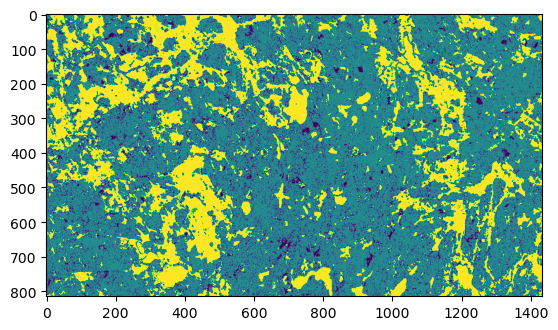

In [16]:
classifierName = 'random_forest'
# Initialize the random forest classifier and give the hyperparameters.
clf_random_forest = RandomForestClassifier(n_estimators=1000, max_depth=600, random_state=0, n_jobs=4)
clf_random_forest = trainModel(x_train, y_train, clf_random_forest, classifierName)
estimateModel(clf_random_forest, x_test, y_test)
predictImage(classifierName, inputImage)
print('Feature importances: \n', clf_random_forest.feature_importances_)

In [11]:
# Predict on whole image and save it as .tif file
def predictImage(modelName, predictImage):
    #Set file paths for input and output files
    predictedClassesFile = outputImageBase + modelName + '_ALL_uusimaa.tif'
    predictedClassesPath = os.path.join(base_folder, predictedClassesFile)
    
    # Read the satellite image
    with rasterio.open(predictImage, 'r') as image_dataset:
        start_time = time.time()    
        
        #Reshape data to 1D as we did before model training
        #image_data = image_dataset.read()
        image_data = image_dataset.read()
        image_data2 = np.transpose(image_data, (1, 2, 0))
        pixels = image_data2.reshape(-1, 27)
        
        #Load the model from the saved file
        modelFilePath = os.path.join(base_folder, ('model_' + modelName + '.sav'))
        trained_model = load(modelFilePath)
        
        # predict the class for each pixel
        prediction = trained_model.predict(pixels)
        
        # Reshape back to 2D
        print('Prediction shape in 1D: ', prediction.shape)
        prediction2D = np.reshape(prediction, (image_dataset.meta['height'], image_dataset.meta['width']))
        #prediction2D = np.reshape(prediction, ( 705, 1213))
        print('Prediction shape in 2D: ', prediction2D.shape)
        
        # Save the results as .tif file.
        # Copy the coorindate system information, image size and other metadata from the satellite image 
        outputMeta = image_dataset.meta
        # Change the number of bands and data type.
        #outputMeta.update(count=1, dtype='uint8')
        outputMeta.update(count=1, dtype='uint8')
        # Writing the image on the disk
        with rasterio.open(predictedClassesPath, 'w', **outputMeta) as dst:
            dst.write(prediction2D, 1)
        plt.imshow(prediction2D)
        print('Predicting took: ', round((time.time() - start_time), 1), ' seconds')

In [ ]:
whole_image = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/UM_max_VH.tif'
predictImage('random_forest', whole_image)

In [ ]:
1

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Model training took:  3.58  seconds
Confusion matrix: 
 [[1218  654  120]
 [ 460 1343  101]
 [ 156   40 2157]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.66      0.61      0.64      1992
         2.0       0.66      0.71      0.68      1904
         3.0       0.91      0.92      0.91      2353

    accuracy                           0.76      6249
   macro avg       0.74      0.74      0.74      6249
weighted avg       0.75      0.76      0.75      6249

Prediction shape in 1D:  (1168710,)
Prediction shape in 2D:  (815, 1434)
Predicting took:  0.5  seconds


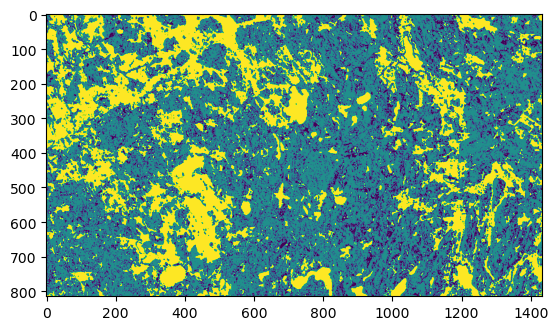

In [19]:
classifierName = 'SGD'    
clf_SGD = SGDClassifier(loss="log", learning_rate='adaptive', alpha=1e-6,  eta0=.01, n_jobs=n_jobs, max_iter=2000, penalty='l1')
clf_SGD = trainModel(x_train, y_train, clf_SGD, classifierName)
#estimateModel(clf_SGD, x_test, y_test)
predictImage(classifierName, inputImage)

In [ ]:
classifierName = 'SGD'    
#clf_SGD = SGDClassifier(loss="log", learning_rate='adaptive', alpha=1e-6,  eta0=.01, n_jobs=n_jobs, max_iter=2000, penalty='l1')
#clf_SGD = trainModel(x_train, y_train, clf_SGD, classifierName)
#estimateModel(clf_SGD, x_test, y_test)
predictImage(classifierName, whole_image)

Model training took:  389.27  seconds
Confusion matrix: 
 [[1404  522   66]
 [ 352 1493   59]
 [  90   53 2210]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.76      0.70      0.73      1992
         2.0       0.72      0.78      0.75      1904
         3.0       0.95      0.94      0.94      2353

    accuracy                           0.82      6249
   macro avg       0.81      0.81      0.81      6249
weighted avg       0.82      0.82      0.82      6249

Prediction shape in 1D:  (1168710,)
Prediction shape in 2D:  (815, 1434)
Predicting took:  29.9  seconds
Feature importances: 
 [0.10942391 0.0169051  0.40513312 0.03545121 0.04584428 0.01381727
 0.00532954 0.00738673 0.00681091 0.03573594 0.01866289 0.0051923
 0.00658249 0.00863381 0.01002751 0.00802367 0.11374749 0.03784673
 0.01546465 0.01656018 0.03848029 0.0013018  0.00140172 0.00527961
 0.00690907 0.02015978 0.00388801]


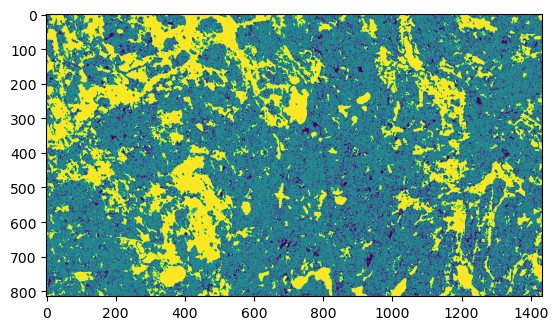

In [20]:
classifierName = 'gradient_boost'    
clf_gradient_boost = GradientBoostingClassifier(n_estimators=500, learning_rate=.02)
clf_gradient_boost = trainModel(x_train, y_train, clf_gradient_boost, classifierName)
estimateModel(clf_gradient_boost, x_test, y_test)
predictImage(classifierName, inputImage)
print('Feature importances: \n', clf_gradient_boost.feature_importances_)

Model training took:  209.09  seconds
Confusion matrix: 
 [[1513  390   89]
 [ 204 1629   71]
 [  35   38 2280]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.86      0.76      0.81      1992
         2.0       0.79      0.86      0.82      1904
         3.0       0.93      0.97      0.95      2353

    accuracy                           0.87      6249
   macro avg       0.86      0.86      0.86      6249
weighted avg       0.87      0.87      0.87      6249

Prediction shape in 1D:  (1168710,)
Prediction shape in 2D:  (815, 1434)
Predicting took:  1886.5  seconds


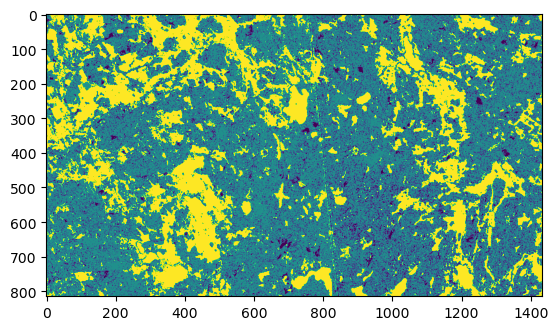

In [22]:
classifierName = 'SVM'        
#clf_svc = SVC(kernel='rbf', gamma='auto',  decision_function_shape='ovr')
#clf_svc = trainModel(x_train, y_train, clf_svc, classifierName)
#estimateModel(clf_svc, x_test, y_test)
predictImage(classifierName, inputImage) #SVM  

In [ ]:
whole_image = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/UM_max_VH.tif'
predictImage('SVM', whole_image)

In [23]:
classifierName = 'SVC_grid_search'        
# Find the optimal parameters for SVM
param_grid = {'C': [1000, 10000], 'gamma': [1, 10]}
# Initialize the grid search, cv is the number of iterations, kept at minimum here for faster results.
grid = GridSearchCV(SVC(), param_grid, verbose=1, n_jobs=4, cv=2)    
# Try different options
grid = trainModel(x_train, y_train, grid, classifierName)
# Plot the best option
print('Best selected parameters: ',format(grid.best_params_))
print('Best estimator: ',format(grid.best_estimator_))
# Test the classifier using test data
estimateModel(grid, x_test, y_test)

# Predict again on the small tile.
predictImage(classifierName, inputImage)  

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Model training took:  721.53  seconds
Best selected parameters:  {'C': 1000, 'gamma': 1}
Best estimator:  SVC(C=1000, gamma=1)
Confusion matrix: 
 [[   0    0 1992]
 [   0    0 1904]
 [   0    0 2353]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      1992
         2.0       0.00      0.00      0.00      1904
         3.0       0.38      1.00      0.55      2353

    accuracy                           0.38      6249
   macro avg       0.13      0.33      0.18      6249
weighted avg       0.14      0.38      0.21      6249



/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

KeyboardInterrupt: 